<a href="https://colab.research.google.com/github/Mahrokh-Eb/Deep-Learning-with-Python/blob/main/catVSdog_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# cat VS dog Classification_V3

In [62]:
# using kaggle dataset, trying to spilit cat and dog classes into train, validation
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
%cd /content/drive/MyDrive/dogVsCat

/content/drive/MyDrive/dogVsCat


In [64]:
#!pip3 install bcolz  

In [65]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline 

import math
import time
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

# Our libraries
from train import train_model
from model_utils import *
from predict_utils import *
from vis_utils import *

In [66]:
DATA_DIR ='/content/drive/MyDrive/dogVsCat/kaggle/'

sz = 224
batch_size = 32

In [67]:
os.listdir(DATA_DIR)

['sampleSubmission.csv', 'DR', 'test1', 'train']

In [68]:
trn_dir = f'{DATA_DIR}train'
test_dir = f'{DATA_DIR}test1'

In [69]:
os.listdir(trn_dir)

['cat', 'dog']

In [70]:
trn_fnames = glob.glob(f'{trn_dir}/*/*')
trn_fnames[:5]

['/content/drive/MyDrive/dogVsCat/kaggle/train/cat/11500.jpg',
 '/content/drive/MyDrive/dogVsCat/kaggle/train/cat/11501.jpg',
 '/content/drive/MyDrive/dogVsCat/kaggle/train/cat/11502.jpg',
 '/content/drive/MyDrive/dogVsCat/kaggle/train/cat/11503.jpg',
 '/content/drive/MyDrive/dogVsCat/kaggle/train/cat/11504.jpg']

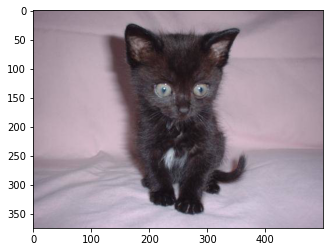

In [71]:
img = plt.imread(trn_fnames[14])
plt.imshow(img);

#Dataset 

In [72]:
tfms = transforms.Compose([
                           transforms.Resize((sz, sz)),
                           transforms.ToTensor(),
                           transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.244, 0.225])
])

train_ds = datasets.ImageFolder(trn_dir, transform=tfms) 

In [73]:
train_ds.class_to_idx

{'cat': 0, 'dog': 1}

In [74]:
len(train_ds)

37499

#Dataloader

In [75]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=32)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


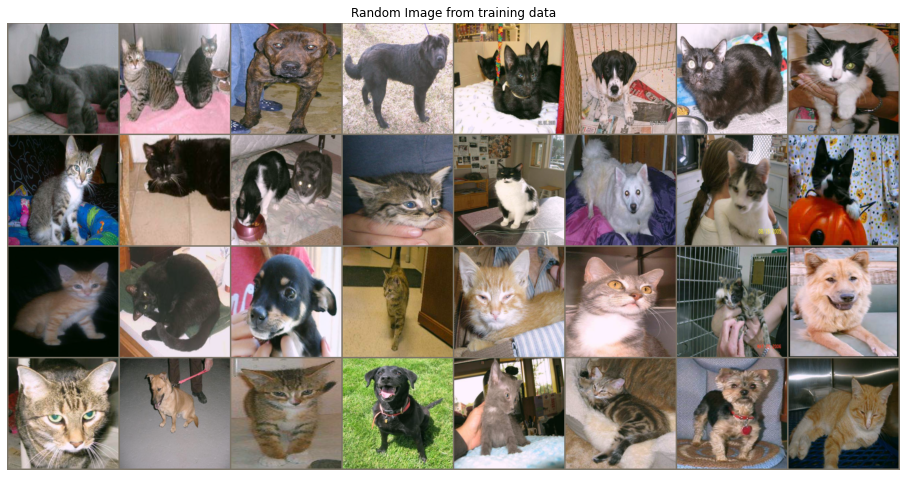

In [76]:
inputs, targets = next(iter(train_dl))
out = torchvision.utils.make_grid(inputs, padding=3)
plt.figure(figsize=(16,12))
imshow(out, title='Random Image from training data')

#Model: CNN

In [77]:
# ??imshow, khode razavi nevesht

In [78]:
class SimpleCNN(nn.Module):
    
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
                nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc = nn.Linear(56* 56* 32, 2)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [79]:
model = SimpleCNN()
if use_gpu:
    model = model.cuda()

In [80]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9)

In [81]:
num_epochs = 10
losses = []
for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_dl):
        inputs = to_var(inputs)
        targets = to_var(targets)
        
        # forwad pass
        optimizer.zero_grad()
        outputs = model(inputs)
        
        # loss
        loss = criterion(outputs, targets)
        losses += [loss.data[0]]
        # backward pass
        loss.backward()
        
        # update parameters
        optimizer.step()
        
        # report
        if (i + 1) % 50 == 0:
            print('Epoch [%2d/%2d], Step [%3d/%3d], Loss: %.4f'
                  % (epoch + 1, num_epochs, i + 1, len(train_ds) // batch_size, loss.data[0]))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [ 1/10], Step [ 50/1171], Loss: 0.5190
Epoch [ 1/10], Step [100/1171], Loss: 0.6220
Epoch [ 1/10], Step [150/1171], Loss: 0.5968
Epoch [ 1/10], Step [200/1171], Loss: 0.5918
Epoch [ 1/10], Step [250/1171], Loss: 0.6931
Epoch [ 1/10], Step [300/1171], Loss: 0.6035
Epoch [ 1/10], Step [350/1171], Loss: 0.6986
Epoch [ 1/10], Step [400/1171], Loss: 0.6996
Epoch [ 1/10], Step [450/1171], Loss: 0.6910
Epoch [ 1/10], Step [500/1171], Loss: 0.6013
Epoch [ 1/10], Step [550/1171], Loss: 0.6044
Epoch [ 1/10], Step [600/1171], Loss: 0.7173
Epoch [ 1/10], Step [650/1171], Loss: 0.6448
Epoch [ 1/10], Step [700/1171], Loss: 0.6681
Epoch [ 1/10], Step [750/1171], Loss: 0.6217
Epoch [ 1/10], Step [800/1171], Loss: 0.5988
Epoch [ 1/10], Step [850/1171], Loss: 0.6223
Epoch [ 1/10], Step [900/1171], Loss: 0.5596
Epoch [ 1/10], Step [950/1171], Loss: 0.7321
Epoch [ 1/10], Step [1000/1171], Loss: 0.6655
Epoch [ 1/10], Step [1050/1171], Loss: 0.6674
Epoch [ 1/10], Step [1100/1171], Loss: 0.6937
Epoch [

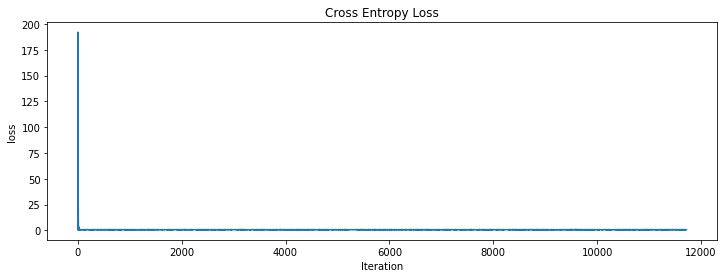

In [82]:
plt.figure(figsize=(12, 4))
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('loss')
plt.title('Cross Entropy Loss');